# Regression model to fit the trend and make prediction

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
import seaborn as sns
%matplotlib inline
from helper import state_df, moving_avg, moving_avg_df, Comb_neighbor, plot_multiple, plot_fit

df = pd.read_csv('./United_States_COVID-19_Cases_and_Deaths_by_State_over_Time.csv')
# convert 'submission_date' data type to datetime 
df['submission_date'] = pd.to_datetime(df['submission_date'], format='%m/%d/%Y')
# select time, state, total cases, new cases, total death, new death as covid
covid=df[['submission_date','state','tot_cases', 'new_case', 'tot_death', 'new_death']]
us_tot=covid.groupby(['submission_date']).sum()
days_since_begin = np.array([i for i in range(len(us_tot.index.values))]).reshape(-1,1)

In [28]:
#polynomial regression for the total cases
poly_reg = PolynomialFeatures(degree=3) #explore degree to get the fit that makes sense
X=days_since_begin
y=us_tot.tot_cases
X_poly = poly_reg.fit_transform(X)
pol_reg = LinearRegression()
pol_reg.fit(X_poly, y)

LinearRegression()

(array([-5000000.,        0.,  5000000., 10000000., 15000000., 20000000.,
        25000000., 30000000., 35000000., 40000000.]),
 <a list of 10 Text major ticklabel objects>)

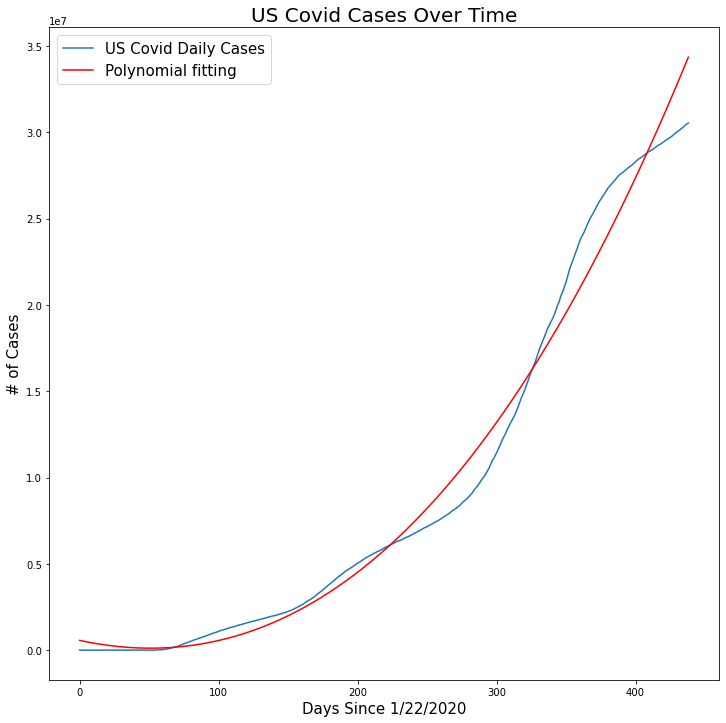

In [29]:
# plot the time-series total cases with fitting 
plt.figure(figsize=(12, 12))
plt.plot(days_since_begin, us_tot.tot_cases)
plt.plot(days_since_begin, pol_reg.predict(poly_reg.fit_transform(days_since_begin)), color='red')
plt.title('US Covid Cases Over Time', size=20)
plt.xlabel('Days Since 1/22/2020', size=15)
plt.ylabel('# of Cases', size=15)
plt.legend(['US Covid Daily Cases','Polynomial fitting'], prop={'size': 15})
plt.xticks(size=10)
plt.yticks(size=10)

In [30]:
# Polynomial regression for the total cases at higher degree
poly_reg = PolynomialFeatures(degree=5)
X=days_since_begin[50:]
y=us_tot.tot_death[50:]
X_poly = poly_reg.fit_transform(X)
pol_reg = LinearRegression()
pol_reg.fit(X_poly, y)

LinearRegression()

(array([-100000.,       0.,  100000.,  200000.,  300000.,  400000.,
         500000.,  600000.]),
 <a list of 8 Text major ticklabel objects>)

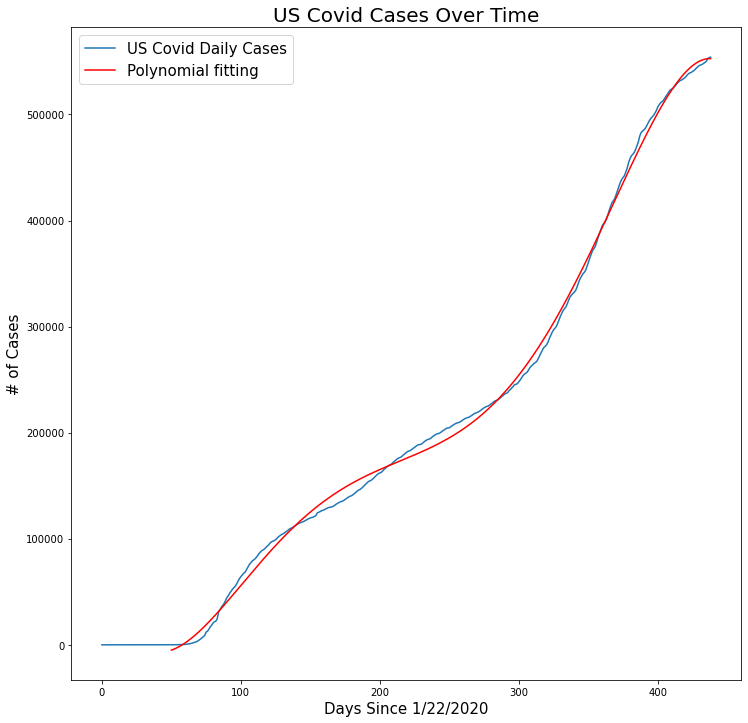

In [31]:
# plot the time-series total cases with fitting 
plt.figure(figsize=(12, 12))
plt.plot(days_since_begin, us_tot.tot_death)
#plt.plot(days_since_begin, pol_reg.predict(poly_reg.fit_transform(days_since_begin)), color='red')
plt.plot(X, pol_reg.predict(poly_reg.fit_transform(X)), color='red')
plt.title('US Covid Cases Over Time', size=20)
plt.xlabel('Days Since 1/22/2020', size=15)
plt.ylabel('# of Cases', size=15)
plt.legend(['US Covid Daily Cases','Polynomial fitting'], prop={'size': 15})
plt.xticks(size=10)
plt.yticks(size=10)

In [32]:
#calculate monthly moving average of the daily increase cases and death
window=30
avg_new_death=moving_avg(us_tot.new_death.values, window)
avg_new_cases=moving_avg(us_tot.new_case.values, window)

In [33]:
# Polynomial regression for the daily increased cases 
poly_reg = PolynomialFeatures(degree=4) #explore the degree (won't be great looking)
X=days_since_begin
y=avg_new_cases
X_poly = poly_reg.fit_transform(X)
pol_reg = LinearRegression()
pol_reg.fit(X_poly, y)

LinearRegression()

(array([-50000.,      0.,  50000., 100000., 150000., 200000., 250000.]),
 <a list of 7 Text major ticklabel objects>)

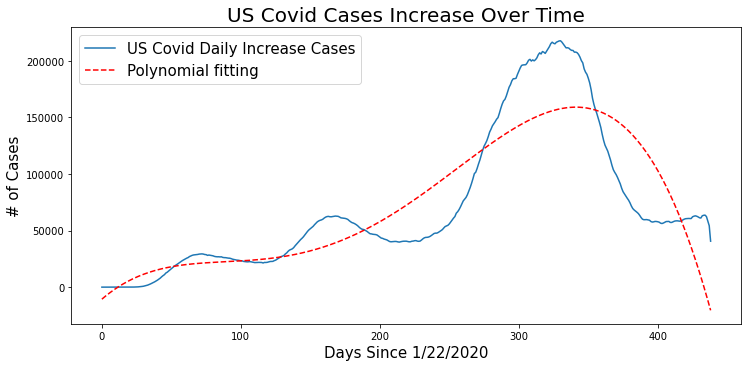

In [34]:
plt.figure(figsize=(12, 12))
plt.subplot(211)
plt.plot(days_since_begin, avg_new_cases)
plt.plot(days_since_begin, pol_reg.predict(poly_reg.fit_transform(days_since_begin)),'r--')
plt.title('US Covid Cases Increase Over Time', size=20)
plt.xlabel('Days Since 1/22/2020', size=15)
plt.ylabel('# of Cases', size=15)
plt.legend(['US Covid Daily Increase Cases','Polynomial fitting'], prop={'size': 15})
plt.xticks(size=10)
plt.yticks(size=10)

# Multi-stage Polynomial Regression

In [35]:
# Divide the trend into a few sections and use polynomial regression for each section
poly_reg = PolynomialFeatures(degree=4)
x,y=days_since_begin,avg_new_cases
X=[x[:70], x[70:150], x[150:280], x[280:385]]
Y=[y[:70], y[70:150], y[150:280], y[280:385]]
Fit=[]
for i in range(len(X)):
    if i>0:
        X_poly = poly_reg.fit_transform(X[i])
        pol_reg = LinearRegression()
        pol_reg.fit(X_poly, Y[i])
        Fit.append(pol_reg.predict(X_poly))
    else:
        Fit.append(Y[i])

#select tail portion to do linear regression
#The moving average (backward) at the tail does not reflect the same amount of time-related information
#Therefore use the raw data to do a linear regression to predict
x_last, y_last=days_since_begin[385:] ,us_tot.new_case.values[385:] #avg_new_cases[380:] 
lin_reg = LinearRegression()
lin_reg.fit(x_last, y_last)
X.append(x_last)
Fit.append(lin_reg.predict(x_last))

In [36]:
#Use the linear model for the tail section to predict future 180 days
x_future=np.array([i+len(days_since_begin) for i in range(180)]).reshape(-1,1)
y_future_pred=lin_reg.predict(x_future)
X.append(x_future)
Fit.append(y_future_pred)
legend=['30-day average new cases', 'Multi-Stage Polynomial Regression', 'Future Prediction']

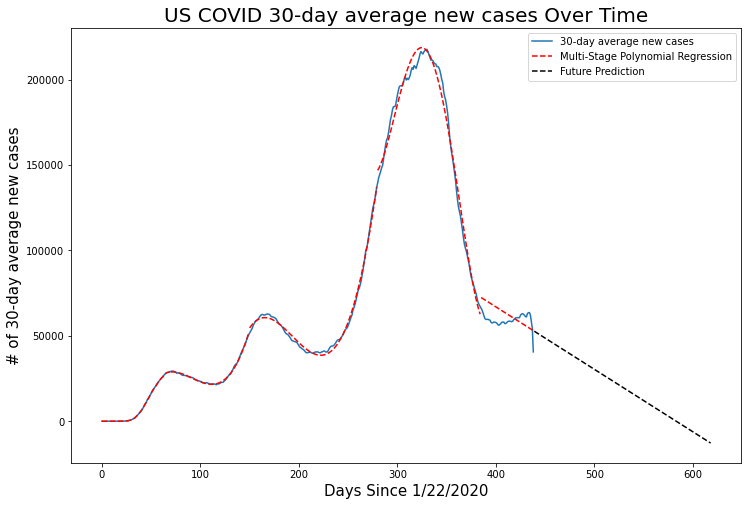

In [37]:
# plot the daily increased cases with multistage fitting and future prediction
plot_fit(x, y, X, Fit, legend)


In [38]:
# Get the amount of days that new case reach 0
turn_around_date=0
for index, num in enumerate(y_future_pred):
    if num<0:
        turn_around_date=x_future[index][0]
        break

In [39]:
#convert the number of days from the beginning to the actual date
start_date=us_tot.index.values[0]
last_date=start_date+ np.timedelta64(turn_around_date,'D')
np.datetime64(last_date, 'D')

numpy.datetime64('2021-08-28T00:00:00.000000000')